# **Bitcoin Price Prediction**


----------------
## **Context** 
----------------

**Bitcoin is a decentralized digital currency** that uses encryption schemes, decentralized consensus, and other mechanisms to verify transactions and ensure security. It is a revolutionary cryptocurrency that has signaled a paradigm shift in the meaning of wealth and payments, and it has attracted extensive attention from investors, researchers, regulators as well as print & online media all over the world.

------------------
## **Objective**
------------------

An unusual feature of Bitcoin price is the **large fluctuation in contrast to traditional financial assets** (such as gold, stock indexes, and commodities). This dataset consists of monthly average closing prices of Bitcoin from Dec 2011 to March 2021. We have to build a time series model using the AR, MA, ARMA & ARIMA models to predict the monthly average closing price of Bitcoin.

--------------------------
## **Data Dictionary**
--------------------------

- `Timestamp`: Date when the price was collected
- `Close`: The closing price of Bitcoin

## **Importing libraries**

**Note**: The Statsmodels library is being downgraded to version 0.12.1 for this case study. This is because the library has only recently been updated, and the latest version may/may not give us the desired Time Series output results. The code below (!pip install statsmodels==0.12.1) may be run to downgrade the library to the right version.

Once the code runs successfully, you may either restart the kernel or restart the Jupyter Notebook before importing the Statsmodels library. It is enough to run the below installation cell for Statsmodels only once. To be sure you are using the correct version of the library, you can use the code in the version check cell right after, and **version 0.12.1** should be good to go.

**Theoretical Background:** 
- AR (Autoregressive Model): Predicts future values using a linear combination of past values. It's useful when past values have a direct influence on the future.

- MA (Moving Average Model): Predicts future values by using past errors. It's good for capturing noise in the data.

- ARMA (Autoregressive Moving Average Model): A combination of AR and MA models, used when both past values and past errors are important in predicting future values.

- ARIMA (Autoregressive Integrated Moving Average): Adds differencing to the ARMA model to handle non-stationarity in the data, which is often present in financial time series like Bitcoin.

In [1]:
# Importing libraries for data manipulation
import pandas as pd

import numpy as np

# Importing libraries for data visualization
import matplotlib.pylab as plt

# Importing an advanced library for data visualization
import seaborn as sns

# Importing library for date manipulation
from datetime import datetime

# To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

# Importing acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importing models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.arima.model import ARIMA

# To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

/Users/owner/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/owner/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## **Loading the dataset**

In [2]:
# Loading the dataset
df = pd.read_csv('bitcoin.csv')

# Looking at first five records of the data
df.head()

,Timestamp,Close
0,31-12-2011,4.482500
1,31-01-2012,6.208932
2,29-02-2012,5.252514
3,31-03-2012,4.961054
4,30-04-2012,4.976416


## **Checking the info** 

In [3]:
# Method to check the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  112 non-null    object 
 1   Close      112 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


**Observations:**

- There are **112 observations and 2 columns** in the data.
- The Timestamp column is of object data type and the closing price is of float data type. We must **convert the `Timestamp` column to datetime data type.** 
- There are **no missing values** in the dataset.

In [4]:
# Converting Timestamp to datetime data type
df.Timestamp = pd.to_datetime(df.Timestamp, infer_datetime_format = True)

Here, **we don't need datetime as a column** because we only need values to build the model. So, we can keep the dates as an index instead of a column in the data. By setting Timestamp as the index, you make it easier to work with time series data, allowing for better time-based indexing and slicing.

In [5]:
# Setting date as the index
df = df.set_index(['Timestamp'])

df.head()

,Close
Timestamp,
2011-12-31,4.482500
2012-01-31,6.208932
2012-02-29,5.252514
2012-03-31,4.961054
2012-04-30,4.976416


Now, let's **visualize the time series** to get an idea how about the trend and/or seasonality within the data.

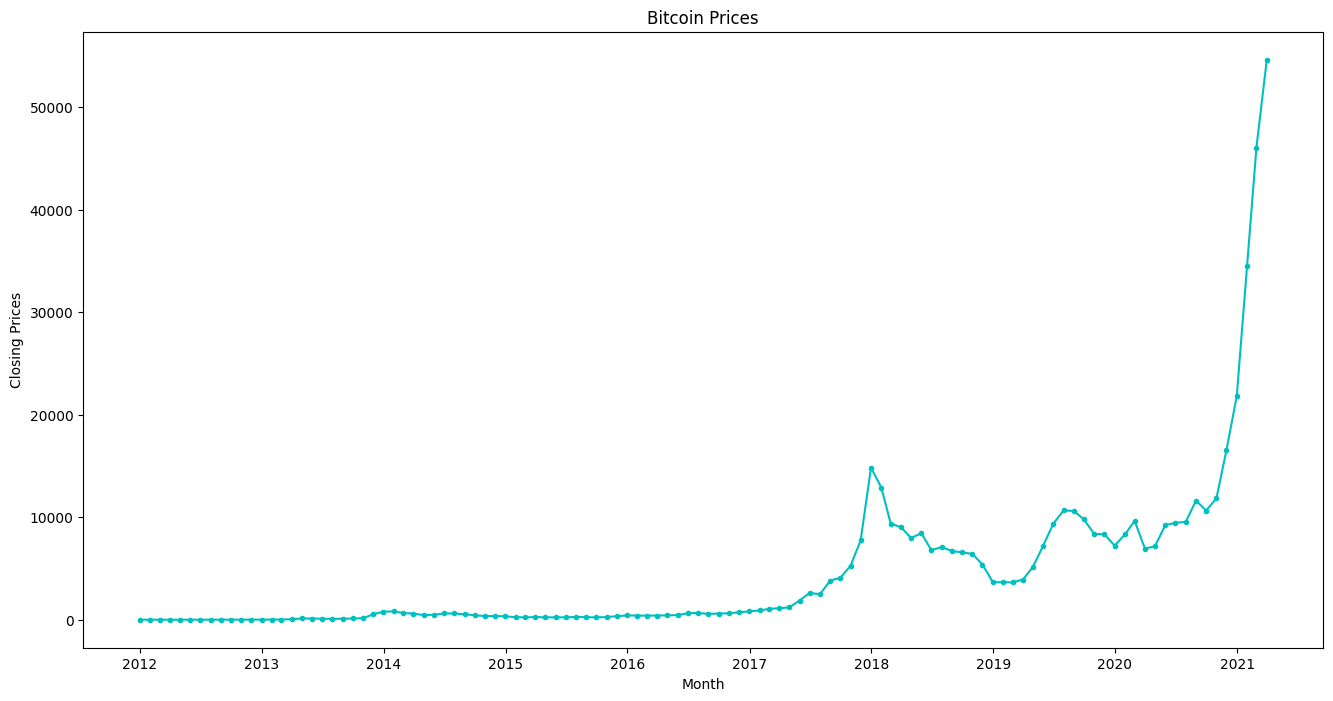

In [6]:
# Visualizing the time series
plt.figure(figsize=(16, 8))

plt.xlabel("Month")

plt.ylabel("Closing Prices")

plt.title('Bitcoin Prices')

plt.plot(df.index, df.Close, color = 'c', marker = '.')

**Observations:**
- We can see that the series has an **upward trend with some seasonality.** The prices have started significantly rising since 2017, and there have been rapid fluctuations since then. **The value of Bitcoin has also increased tremendously in the year 2021 alone.**
- Before building models, it’s essential to check if the time series is stationary, as many time series models (like ARIMA) assume stationarity.


Let us first split the dataset into train and test data.

## **Splitting the dataset**

We'll consider the data from the **last 12 months as the test data** and the remaining data as the train data.

In [7]:
# Splitting the data into train and test sets
df_train, df_test = df.iloc[:-12], df.iloc[-12:]

print(df_train)

print(df_test)

                  Close
Timestamp              
2011-12-31     4.482500
2012-01-31     6.208932
2012-02-29     5.252514
2012-03-31     4.961054
2012-04-30     4.976416
...                 ...
2019-11-30  8342.407325
2019-12-31  7240.923794
2020-01-31  8321.166136
2020-02-29  9646.348210
2020-03-31  6928.948538

[100 rows x 1 columns]
                   Close
Timestamp               
2020-04-30   7181.912395
2020-05-31   9236.102515
2020-06-30   9459.375927
2020-07-31   9545.246114
2020-08-31  11636.379750
2020-09-30  10654.757360
2020-10-31  11836.958820
2020-11-30  16530.432870
2020-12-31  21811.295270
2021-01-31  34553.599450
2021-02-28  46077.063200
2021-03-31  54641.412970


Now, let us check the **rolling mean and standard deviation** of the series to **visualize if the series has any trend or seasonality.**

## **Testing the stationarity of the series**

- The rolling mean and standard deviation with a window size of 12. This gives you a moving average and a moving standard deviation over the past 12 observations (months).
- Rolling statistics help visualize trends and seasonality in the data. A consistent rolling mean indicates that the series has a trend, while a rolling standard deviation that changes over time suggests non-stationarity.

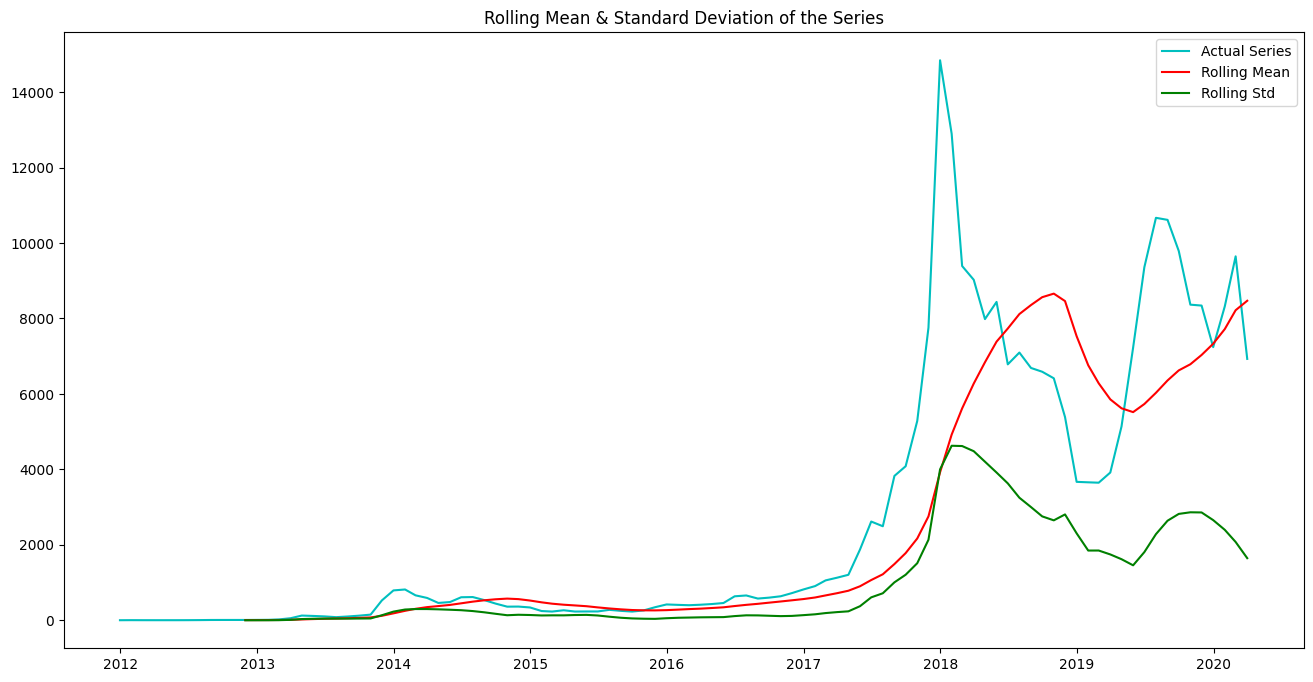

In [8]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
rolmean = df_train.rolling(window = 12).mean()

rolstd = df_train.rolling(window = 12).std()

# Visualizing the rolling mean and standard deviation
plt.figure(figsize = (16, 8))

actual = plt.plot(df_train, color = 'c', label = 'Actual Series')

rollingmean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean') 
rollingstd = plt.plot(rolstd, color='green', label='Rolling Std')

plt.title('Rolling Mean & Standard Deviation of the Series')

plt.legend()

plt.show()

**Observations:**
- To train a Time Series model the data has to be stationary and we can determine that from the rolling mean and rolling average (They have to have constant mean and variance), so over the period of time the mean and variance should not change too much. Clearly from the plot above we see that both mean and variance are changing.
- We can see that **there is an upward trend in the series.**
- We can confirm that **the series is not stationary.**

We can also use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not.
The null and alternate hypotheses for the ADF Test are defined as: 
- **Null hypothesis:** The Time Series is non-stationary
- **Alternative hypothesis:** The Time Series is stationary

In [9]:
# Define a function to use adfuller test
def adfuller(data):
    
  #Importing adfuller using statsmodels
    from statsmodels.tsa.stattools import adfuller
    
    print('Dickey-Fuller Test: ')
    
    adftest = adfuller(data['Close'])
    
    adfoutput = pd.Series(adftest[0:4], index = ['Test Statistic', 'p-value', 'Lags Used', 'No. of Observations'])
    
    for key, value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    
    print(adfoutput)

adfuller(df_train)

Dickey-Fuller Test: 
Test Statistic          -1.837394
p-value                  0.362061
Lags Used                1.000000
No. of Observations     98.000000
Critical Value (1%)     -3.498910
Critical Value (5%)     -2.891516
Critical Value (10%)    -2.582760
dtype: float64


**Interpreting the Results:** 
- ADF Statistic: This value is compared with critical values. If it is smaller than the critical value at a given confidence level (e.g., 1%, 5%, 10%), we reject the null hypothesis.
- p-value: If the p-value is less than 0.05, the series is considered stationary. If the p-value is greater than 0.05, the series is non-stationary.
- Critical Values: These are benchmark values at different significance levels (1%, 5%, 10%) that help in interpreting the test statistic.

**Observations:**
1. From the above test, we can see that the **p-value is around 0.36, i.e., > 0.05** (for 95% confidence intervals) therefore, **we fail to reject the null hypothesis.**
2. Also ADF statistics is **NOT** smaller than the critical value, so we fail to reject the null hypothesis.
3. Hence, **we can confirm that the series is non-stationary.**

## **Making the series stationary**

### 1. **Moving Average (MA):**

**Moving Average (MA)** is one of the simplest and most commonly used smoothing techniques. It works by averaging a specific number of consecutive data points (a window) over the time series.
- **Purpose:** It smooths short-term fluctuations and reveals longer-term trends.
- **Usage:** It's particularly effective when the underlying pattern of the series is constant, without much fluctuation.

### 2. **Weighted Moving Average (WMA):**

A **Weighted Moving Average (WMA)** assigns different weights to past observations, giving more importance to recent data points compared to older ones.
- **Purpose:** Gives more weight to recent observations, making the smoothing more sensitive to recent changes.
- **Usage:** This technique is useful when recent data points are more relevant than older ones.

### 3. **Exponential Smoothing (EWMA or SES):**

**Exponential Weighted Moving Average (EWMA)** or **Single Exponential Smoothing (SES)** is a popular smoothing technique that places exponentially decreasing weights on past observations. This means that recent observations have more influence than older ones.
- **Purpose:** Exponentially smoother than simple moving average and adjusts more quickly to recent changes in data.
- **Usage:** Effective when you expect the most recent data points to be more indicative of future behavior.

### 4. **Double Exponential Smoothing (Holt’s Linear Trend Model):**

**Double Exponential Smoothing** extends single exponential smoothing by considering both the level and the trend of the time series. It’s useful for time series that have trends.
- **Purpose:** Captures both the level and the trend of the data.
- **Usage:** Suitable for data that exhibit a trend.

### 5. **Triple Exponential Smoothing (Holt-Winters Method):**

**Triple Exponential Smoothing (Holt-Winters Method)** extends double exponential smoothing by adding a third component for seasonality.
- **Purpose:** Captures level, trend, and seasonality in the time series.
- **Usage:** Effective for data with both trend and seasonal components.



### Summary of Smoothing Techniques:

| Technique                      | Use Case                                       | Key Formula                                                                                       |
|---------------------------------|------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **Moving Average (MA)**         | For basic smoothing of trends.                 | $$
SMA_t = \frac{X_{t} + X_{t-1} + \cdots + X_{t-k+1}}{k}
$$                                        |
| **Weighted MA (WMA)**           | When recent data is more important.            | $$
WMA_t = \frac{w_1 X_t + w_2 X_{t-1} + \cdots + w_k X_{t-k+1}}{w_1 + w_2 + \cdots + w_k}
$$                           |
| **Exponential Smoothing**       | For fast adjustment to recent changes.         | $$
S_t = \alpha X_t + (1 - \alpha) S_{t-1}
$$                                                      |
| **Double Exponential Smoothing**| When data has a trend.                         | $$L_t = \alpha X_t + (1 - \alpha) (L_{t-1} + T_{t-1})$$ <br> $$T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1}$$  |
| **Triple Exponential Smoothing**| When data has trend and seasonality.           | $$L_t = \alpha \frac{X_t}{S_{t-m}} + (1 - \alpha) (L_{t-1} + T_{t-1})$$ <br> $$T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1}$$ <br> $$S_t = \gamma \frac{X_t}{L_t} + (1 - \gamma) S_{t-m}$$ |




We can use some of the following methods to convert a non-stationary series into a stationary one:
1. **Log Transformation:** To stabilize variance  
2. **By differencing the series (lagged series):** To remove trends

Let's first use a log transformation over this series to remove exponential variance and check the stationarity of the series again.

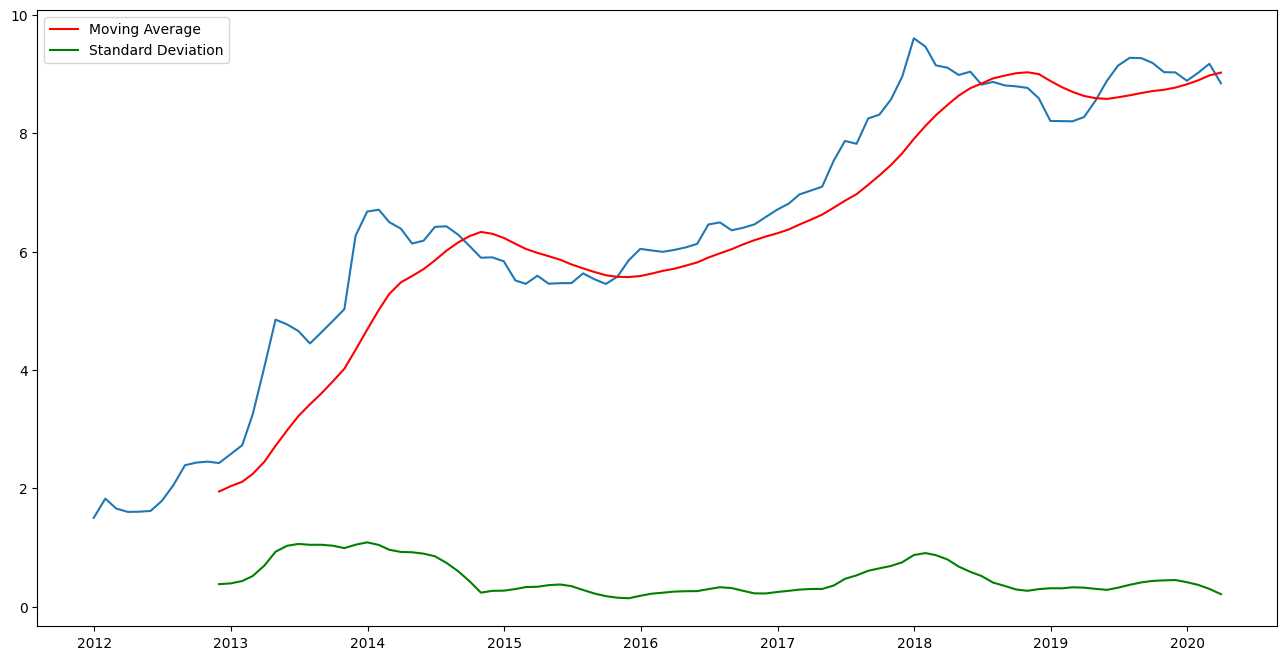

In [10]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize = (16, 8))

df_log = np.log(df_train)

MAvg = df_log.rolling(window = 12).mean()

MStd = df_log.rolling(window = 12).std()

plt.plot(df_log)

plt.plot(MAvg, color='r', label = 'Moving Average')

plt.plot(MStd, color='g', label = 'Standard Deviation')

plt.legend()

plt.show()

**Observations:**
- Since **we can still see the upward trend in the series**, we can conclude that **the series is still non-stationary.** 
- However, the standard deviation is almost constant, which implies that **now the series has a constant variance.**

**Let's shift the series by order 1 (or by 1 month) and apply differencing (using lagged series),** and then check the rolling mean and standard deviation.

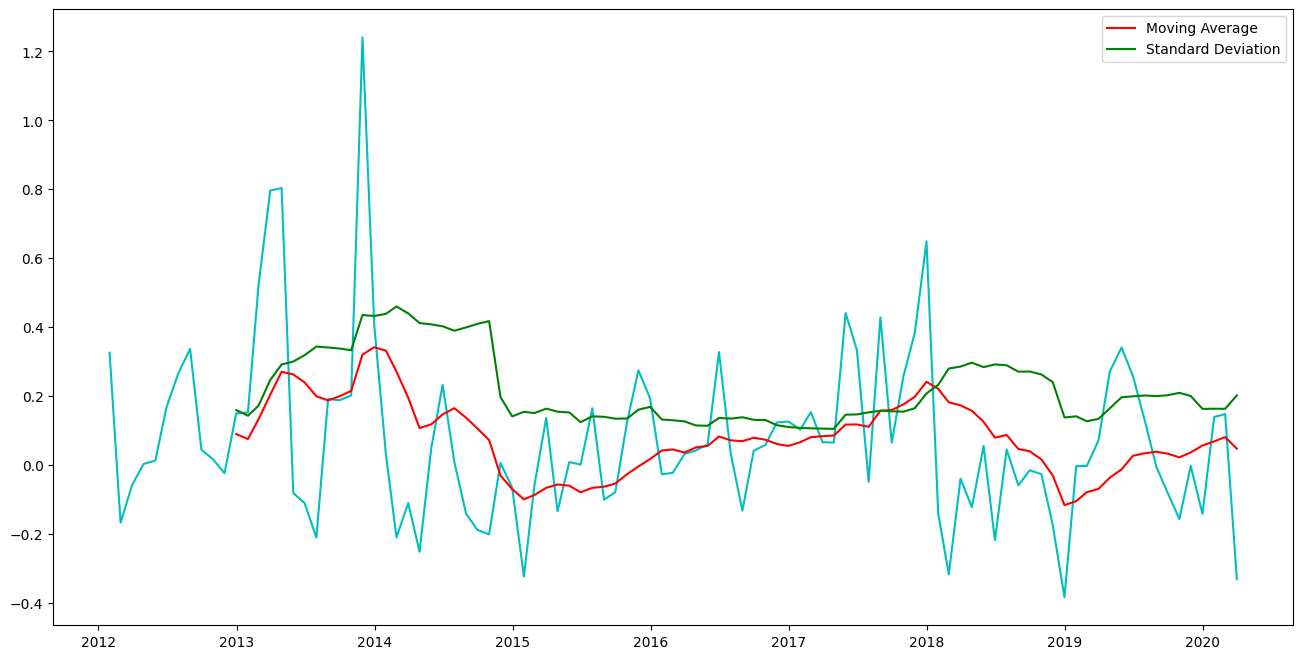

In [11]:
# Fixing the figure size
plt.figure(figsize = (16, 8))

df_shift = df_log - df_log.shift(periods = 1)

MAvg_shift = df_shift.rolling(window = 12).mean()

MStd_shift = df_shift.rolling(window = 12).std()

plt.plot(df_shift, color = 'c')

plt.plot(MAvg_shift, color = 'red', label = 'Moving Average')

plt.plot(MStd_shift, color = 'green', label = 'Standard Deviation')

plt.legend()

plt.show()

# Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

**Observations:**
- **The mean and the standard deviation seem to be constant over time.** Let us use the adfuller test to check the stationarity.

In [12]:
adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic         -6.174833e+00
p-value                 6.669466e-08
Lags Used               0.000000e+00
No. of Observations     9.800000e+01
Critical Value (1%)    -3.498910e+00
Critical Value (5%)    -2.891516e+00
Critical Value (10%)   -2.582760e+00
dtype: float64


**Observations:**
- We can see that **the p-value is now far lesser than 0.05** (for 95% confidence interval), **therefore, we can reject the null hypothesis that the series is non-stationary.**

We can conclude that **the series is now stationary.** Let's decompose the time series to check its different components.

### Why Didn't We Use Smoothing Techniques?

The primary goal of this process is to **make the series stationary**, which is a prerequisite for many time series models like ARIMA. Smoothing techniques like **Simple Moving Average (SMA)** or **Exponential Smoothing (EWMA)** are used to **reduce noise** and highlight the underlying trend, but they **do not remove trends or seasonality**. 

In contrast, methods like **log transformation** stabilizes variance (reduces heteroscedasticity). It's often used when we see an exponential trend or increasing volatility over time (i.e., variance that grows with the mean). and **differencing** removes trends (linear or non-linear) by subtracting the previous observation from the current observation, effectively de-trending the data. Both are key steps in making a series stationary.

Smoothing techniques are more useful for **highlighting trends** or **preparing data for forecasting** by removing noise, rather than making the series stationary.

### When to Use Smoothing Techniques vs. Other Methods

Here’s a comparison to help you understand **when to use what**:

#### 1. **Smoothing Techniques** (like Moving Average, Exponential Smoothing, etc.)
   - **Goal**: To **reduce noise** in the data, highlight trends, and smooth out short-term fluctuations.
   - **When to Use**:
     - When you want to **analyze trends** over time but not necessarily make the series stationary.
     - When preparing data for **trend analysis** or **visualization** (e.g., smoothing volatile stock prices to see the overall direction).
     - If you’re using models that don’t require stationarity, such as **Exponential Smoothing** models like Holt-Winters (used for seasonal data with trend).

   - **Example Use Case**:
     - You are analyzing sales data and want to see a **smooth version of the data** to get a better sense of the trend over time, ignoring short-term fluctuations.
   
#### 2. **Transformation Methods** (like Log Transformation, Differencing)
   - **Goal**: To **make the series stationary** by removing trends, seasonality, and stabilizing the variance.
   - **When to Use**:
     - When you are preparing a time series for **forecasting models** like **ARIMA**, which require the series to be stationary.
     - When the data shows an **upward or downward trend**, and you need to **remove that trend**.
     - When the data has **non-constant variance** (heteroscedasticity), which affects forecasting accuracy.
     
   - **Example Use Case**:
     - You want to build an ARIMA model to predict future Bitcoin prices. The prices are trending upward, so you apply **log transformation** and **differencing** to remove the trend and stabilize the variance, making the series stationary.

### Key Considerations for Choosing What to Use:

1. **Does Your Model Require Stationarity?**
   - **Yes**: If you are using models like **ARIMA**, **SARIMA**, or **VAR**, you need to **make the series stationary** first. Use **log transformation**, **differencing**, and other transformation techniques.
   - **No**: If you are using models that can handle trends and seasonality (e.g., **Exponential Smoothing**, **Holt-Winters**), you don’t need to make the series stationary, but you may use **smoothing techniques** to reduce noise.

2. **Is the Series Highly Noisy?**
   - If your time series is very noisy (with lots of random fluctuations), you may want to apply **smoothing techniques** like **Simple Moving Average (SMA)** or **Exponential Weighted Moving Average (EWMA)** to see the underlying trend more clearly.

3. **Do You Need to Forecast?**
   - For long-term forecasts that require understanding both trends and seasonality, models like **Holt-Winters** or **SARIMA** might be more appropriate.
   - For short-term forecasts where trends need to be eliminated, ARIMA is more appropriate after **stationarizing** the series.

### A Summary of When to Use What:

| **Scenario**                              | **Use Smoothing**                       | **Use Transformations**                |
|-------------------------------------------|-----------------------------------------|----------------------------------------|
| **Highlight trend and reduce noise**      | Yes (use SMA, WMA, EWMA, etc.)          | No                                     |
| **Prepare data for ARIMA or SARIMA model**| No                                      | Yes (use log transformation, differencing) |
| **Handle seasonality or trend for forecasting** | Yes (use Holt-Winters for seasonality)  | Yes (use transformations for stationarity in ARIMA) |
| **Stabilize variance**                    | No                                      | Yes (log transformation helps)         |
| **Forecast with Exponential Smoothing**   | Yes (use Holt-Winters or EWMA)          | No (unless stationarity is required)   |

### Conclusion:

- Here we focused on **removing trends** and making the series **stationary** for the Dickey-Fuller test and possible future ARIMA modeling. Smoothing techniques would not let us achieve stationarity.
- **How you can conclude the results**: After applying log transformation and differencing, the **ADF test** showed a low **p-value** (less than 0.05), meaning that the series is now **stationary**. This is critical because most time series forecasting models, such as ARIMA, require the series to be stationary for accurate predictions.


## **Decomposing the time series components into Trend, Seasonality, and Residual**

- Trend: Represents the long-term movement or direction of the series (e.g., upward or downward trend). This is the smoothed version of your original series that shows the overall direction of the data over time. It captures the general pattern without short-term fluctuations.
- Seasonality: Represents repeating patterns or cycles (e.g., yearly seasonality, monthly seasonality). This captures regular cycles in the data. For instance, if you're looking at monthly sales data, seasonality might capture yearly fluctuations, such as peak sales in December.
- Residual: The remaining noise or irregularities after removing trend and seasonality. This is the noise or irregular component that remains after removing both trend and seasonality. It contains the random fluctuations that cannot be explained by the trend or seasonal patterns.
  

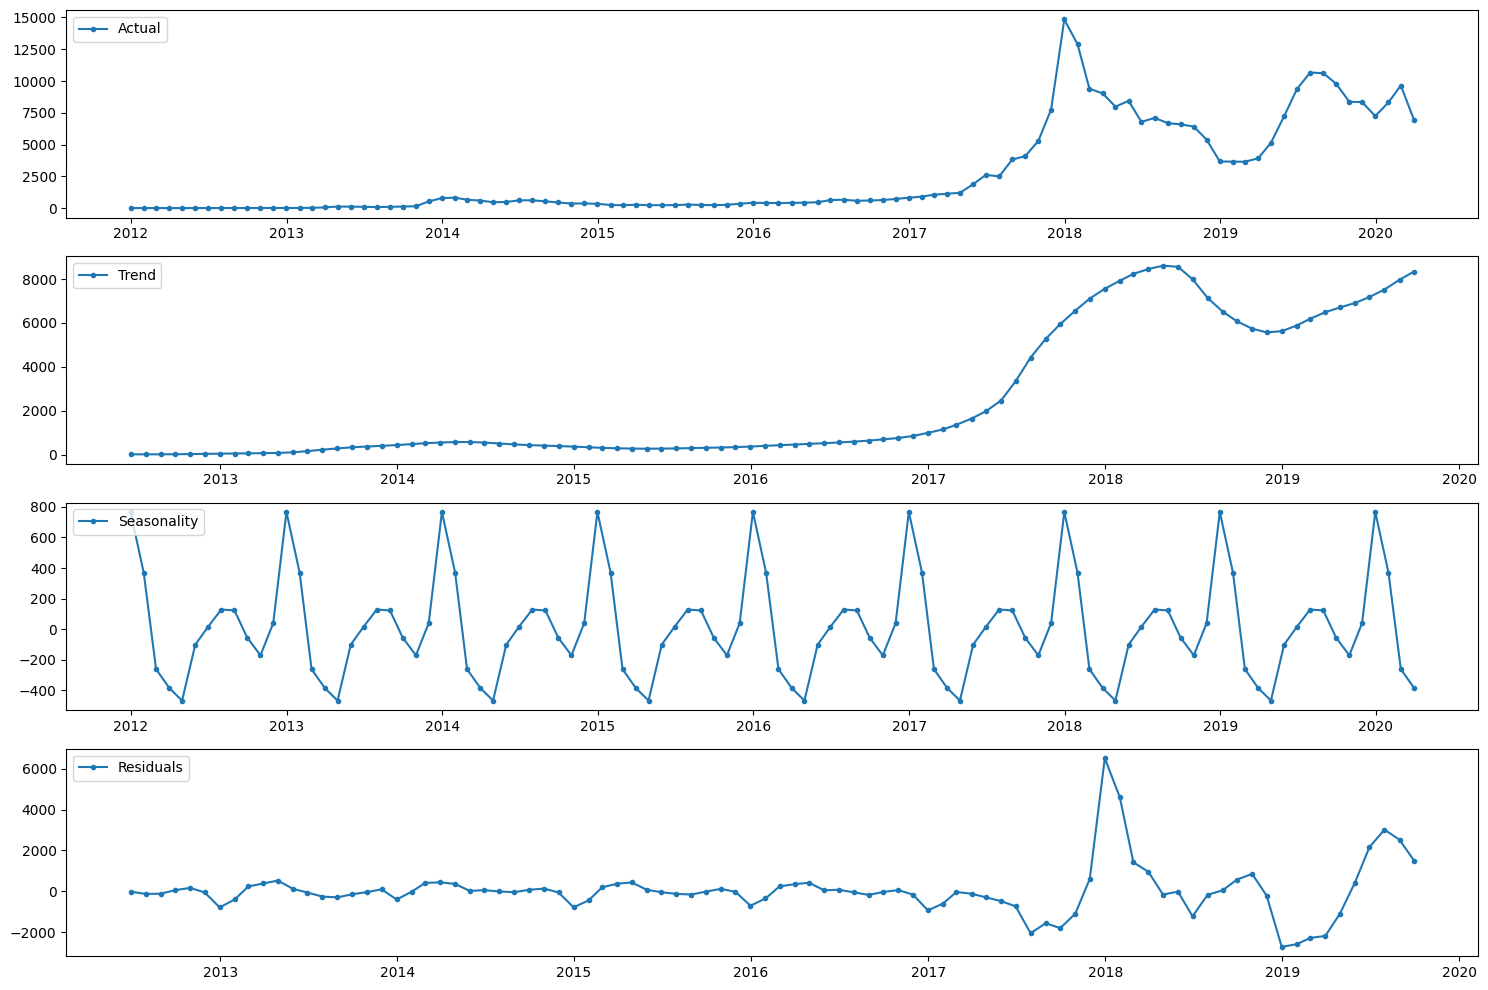

In [18]:
# Importing the seasonal_decompose to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df_train)

trend = decomp.trend

seasonal = decomp.seasonal

residual = decomp.resid

plt.figure(figsize = (15, 10))

plt.subplot(411)

plt.plot(df_train, label = 'Actual', marker = '.')

plt.legend(loc = 'upper left')

plt.subplot(412)

plt.plot(trend, label = 'Trend', marker = '.')

plt.legend(loc = 'upper left')

plt.subplot(413)

plt.plot(seasonal, label = 'Seasonality', marker = '.')

plt.legend(loc = 'upper left')

plt.subplot(414)

plt.plot(residual, label = 'Residuals', marker = '.')

plt.legend(loc = 'upper left')

plt.tight_layout()

**Observations:**

- The significant trend indicates that Bitcoin has experienced long-term growth, possibly driven by factors such as increased public awareness, institutional investment, or technological developments in the blockchain space.

- The clear seasonality pattern reveals that Bitcoin prices are cyclical, with regular peaks during the winter months, particularly in December and January till May, and gradual declines afterward. This insight is valuable for investors who may want to time their investments or withdrawals according to the historical seasonal trends.

- The residuals reflect some level of unpredictability, as certain external events affecting Bitcoin prices are not captured by the trend or seasonality. These events are likely unpredictable, but overall, the decomposition suggests that the price behavior can largely be understood through long-term trends and seasonal patterns.

**Now, let's move on to the model building section. First, we will plot the `ACF` and `PACF` plots to get the values of p and q, i.e., the order of AR and MA models to be used.**

## **ACF and PACF plots**

**Plotting the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models.**

<Figure size 1600x800 with 0 Axes>

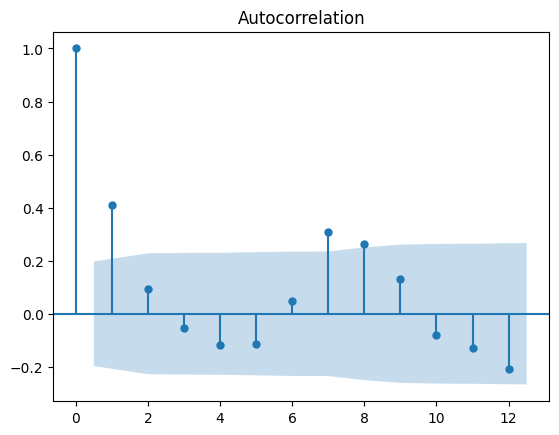

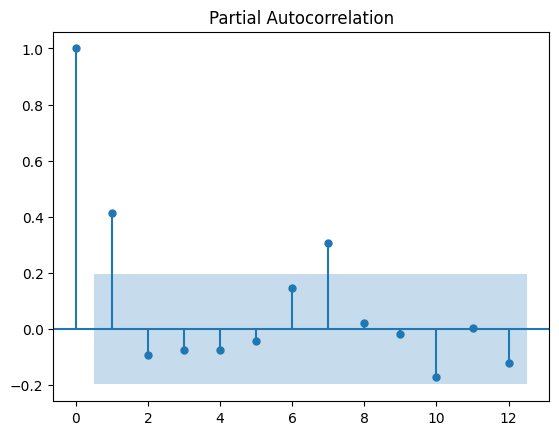

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize = (16, 8))

plot_acf(df_shift, lags = 12) 

plt.show()

plot_pacf(df_shift, lags = 12) 

plt.show()

The ACF (Auto-Correlation Function) and PACF (Partial Auto-Correlation Function) plots help us determine the order of the AR (AutoRegressive) and MA (Moving Average) components, respectively, for models like AR, MA, ARMA, and ARIMA.

**Here’s a breakdown of what we’re observing:**

### 1. **Auto-Correlation Function (ACF) Plot**:
- The **ACF plot** shows how the time series data points are correlated with their previous values (lags).
- If we see significant correlations at certain lags (i.e., bars extending beyond the blue confidence intervals), it suggests that past values at those lags are influencing current values.
  
In our case:
- **The ACF plot extends beyond the significant boundary up to lag 7**, meaning that the correlation between the current value and its lagged values is significant up to lag 7.
- This implies that an **MA (Moving Average) model with lag \( q = 7 \)** is likely to be effective, meaning the current value of the series depends on the last 7 lagged error terms.

### 2. **Partial Auto-Correlation Function (PACF) Plot**:
- The **PACF plot** shows the correlation between a time series and its lags, **excluding the influence of intermediate lags**.
- In other words, it measures the direct relationship between an observation and its lag, removing the indirect effects.
  
In our case:
- **The PACF plot shows significance up to lag 7** before it drops off, meaning that the relationship between the current value and its lagged values (after removing intermediate effects) is significant up to lag 7.
- This suggests that an **AR (AutoRegressive) model with lag \( p = 7 \)** would likely capture the dynamics of the series well. This means the current value of the series depends on the past 7 values.

### **Summary**:
- From the ACF and PACF plots, you can infer that **both the AR and MA components** of the model should use a lag of 7. This indicates:
  - **p = 7** for the AR component.
  - **q = 7** for the MA component.

## **AR Model**

Autoregressive (AR) models predict the value of the time series based on its own past values. Here we will use the AR model with 7 lags (i.e., the past 7 observations) to predict future values.

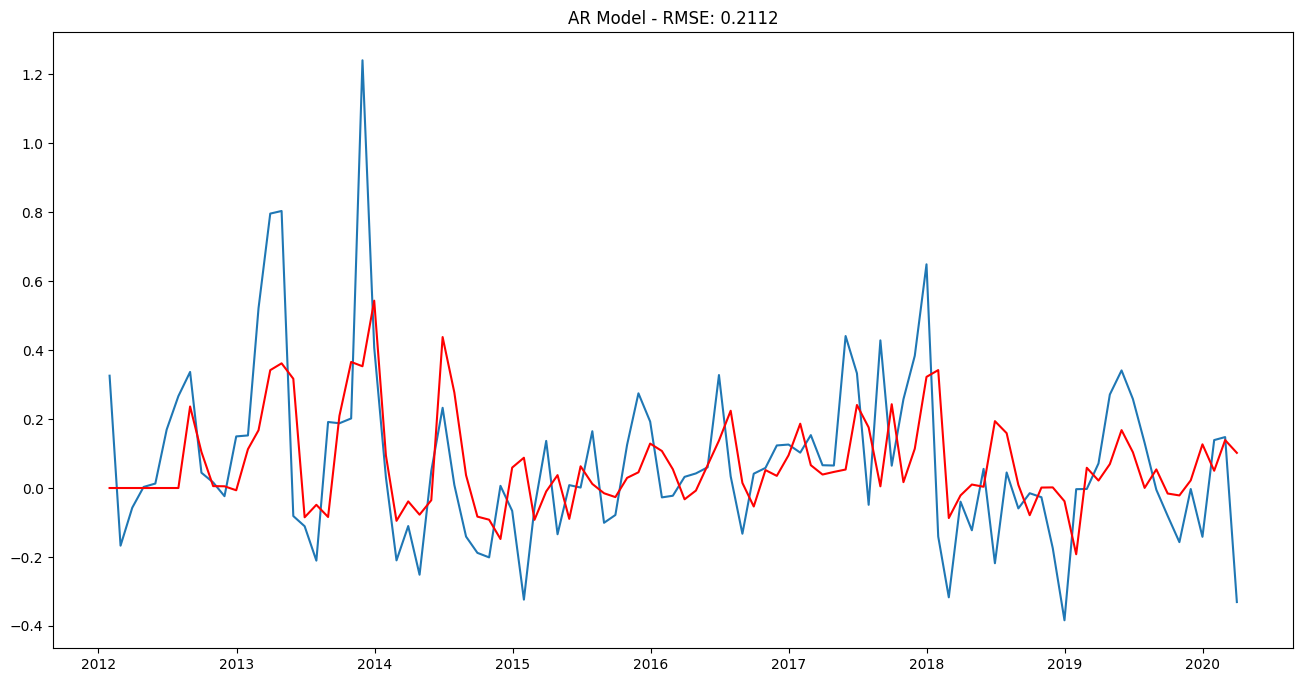

In [20]:
# Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize = (16, 8))

# Using number of lags as 7
model_AR = AutoReg(df_shift, lags = 7)

results_AR = model_AR.fit()

plt.plot(df_shift)

predict = results_AR.predict(start = 0, end = len(df_shift) - 1)

# Converting NaN values to 0
predict = predict.fillna(0)

plt.plot(predict, color = 'red')

# Calculating rmse
plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict, df_shift['Close'], squared = False))

plt.show()

RMSE is a measure of the model’s prediction error. It calculates the average difference between the predicted and actual values, taking the square root to make it interpretable (in the same units as the data). Lower RMSE is better, as it means less error.

- We can see that **by using the AR model, we get root mean squared error (RMSE) = 0.2112**.

**Let's check the AIC value** of the model.

In [21]:
# Checking the AIC value
results_AR.aic #-2.896354867736574

-2.896354867736574

AIC is used to assess the model's fit, with a focus on balancing accuracy with simplicity. It penalizes models that use too many parameters, so a lower AIC indicates a better model fit.

Now, let's build MA, ARMA, and ARIMA models and see if we can get a better model.

## **MA Model**

Moving Average (MA) models predict the value based on past errors (residuals), instead of past observations. We will create an MA(7) model, meaning it will use the past 7 error terms to predict future values.

To implement the MA model, we will use the ARIMA model with p=0, d=0, and q=7 (i.e., an ARIMA(0,0,7) model, which behaves like a Moving Average model with lag 7).

**We will be using an ARIMA model with p = 0 and d = 0 so that it works as an MA model.**

Setting d=0 means we are not applying any differencing to the data. This is appropriate when your series is already stationary (or has been made stationary through previous transformations, like log transformation or differencing outside the model).

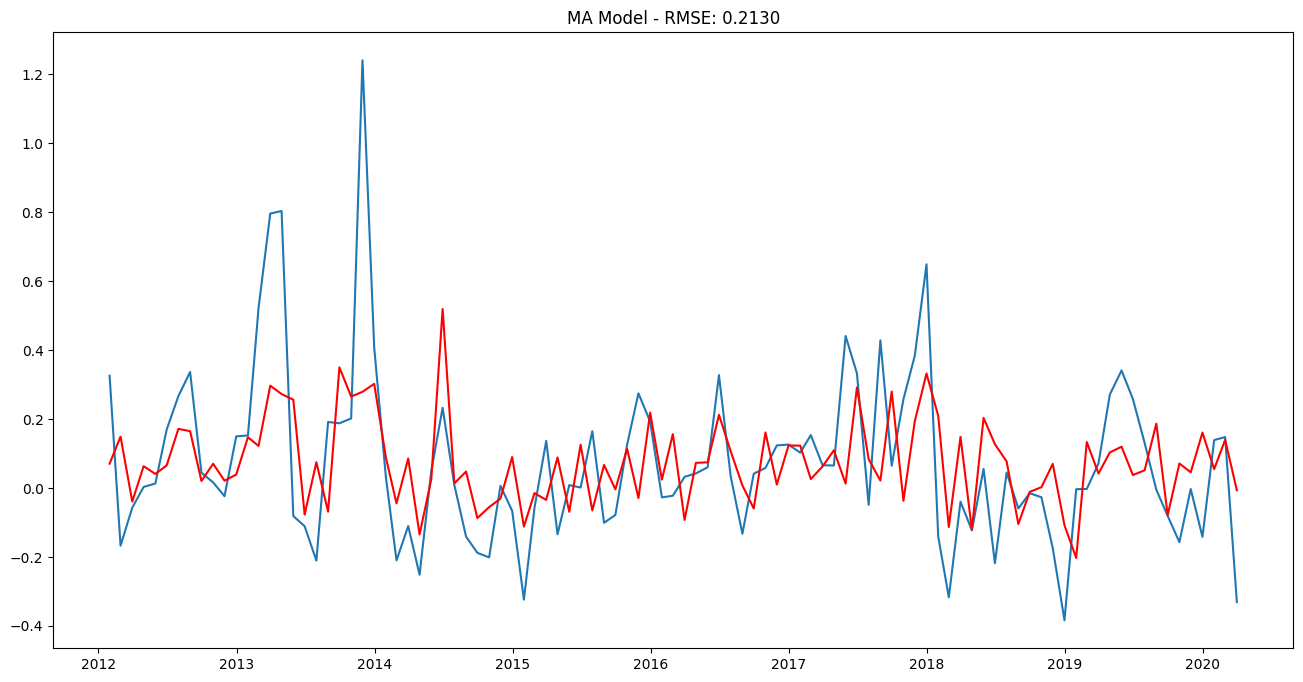

In [22]:
plt.figure(figsize = (16, 8))

# Using p=0, d = 0, q = 7
model_MA = ARIMA(df_shift, order = (0, 0, 7))

results_MA = model_MA.fit()

plt.plot(df_shift)

plt.plot(results_MA.fittedvalues, color = 'red')

plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues, df_shift['Close'], squared = False))

plt.show()

- **The MA model is giving a slightly higher RMSE** when compared to the AR model.

Let's check the AIC value of the model.

In [23]:
# Calculating the AIC value
results_MA.aic #6.9906694429340455

-6.9906694429340455

- **The MA model is giving a lower AIC** when compared to the AR model, implying that **the MA model fits the training data better.**

## **ARMA Model**

We will be using an **ARIMA model with p = 7 and q = 7** (as observed from the ACF and PACF plots) **and d = 0 so that it works as an ARMA model.**

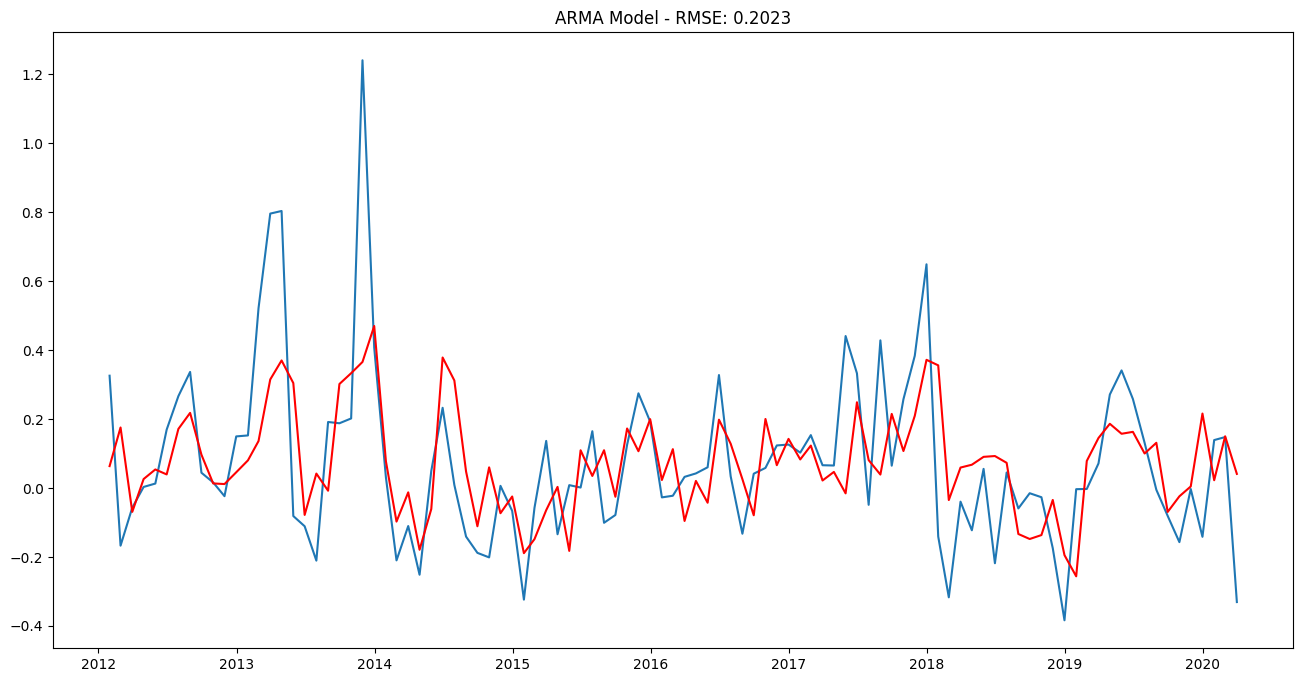

In [24]:
plt.figure(figsize = (16, 8))

# Using p = 7, d = 0, q = 7
model_ARMA = ARIMA(df_shift, order = (7, 0, 7))

results_ARMA = model_ARMA.fit()

plt.plot(df_shift)

plt.plot(results_ARMA.fittedvalues, color = 'red')

plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues, df_shift['Close'], squared = False))

plt.show()

- **The ARMA model is giving a lower RMSE in comparison to AR and MA models.**

**Let's check the AIC value** of the model.

In [25]:
# Calculating the AIC value
results_ARMA.aic #-3.977161184720863

-3.977161184720863

- **The AIC value of the ARMA model is less than the AR model but greater than the MA model.** 

**Let us try using the ARIMA model.**

## **ARIMA Model**

We will be using an **ARIMA model with p = 7, d = 1, & q = 7**.

Since we are using d = 1 in the ARIMA model, it will result in double differencing of the df_log series. So, we need double shifted series in order to calculate the RMSE of the model.

In [36]:
# Getting double differenced series
df_shift2 = df_log - df_log.shift(periods = 2)

df_shift2.dropna(inplace = True)

In [37]:
df_shift2.shape

(98, 1)

In [35]:
model_ARIMA = ARIMA(df_shift, order = (7, 1, 7))
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues

Timestamp
2012-01-31    0.000000
2012-02-29    0.325808
2012-03-31   -0.070933
2012-04-30    0.006204
2012-05-31    0.067088
                ...   
2019-11-30    0.115488
2019-12-31    0.145350
2020-01-31    0.073599
2020-02-29   -0.006564
2020-03-31    0.098264
Length: 99, dtype: float64

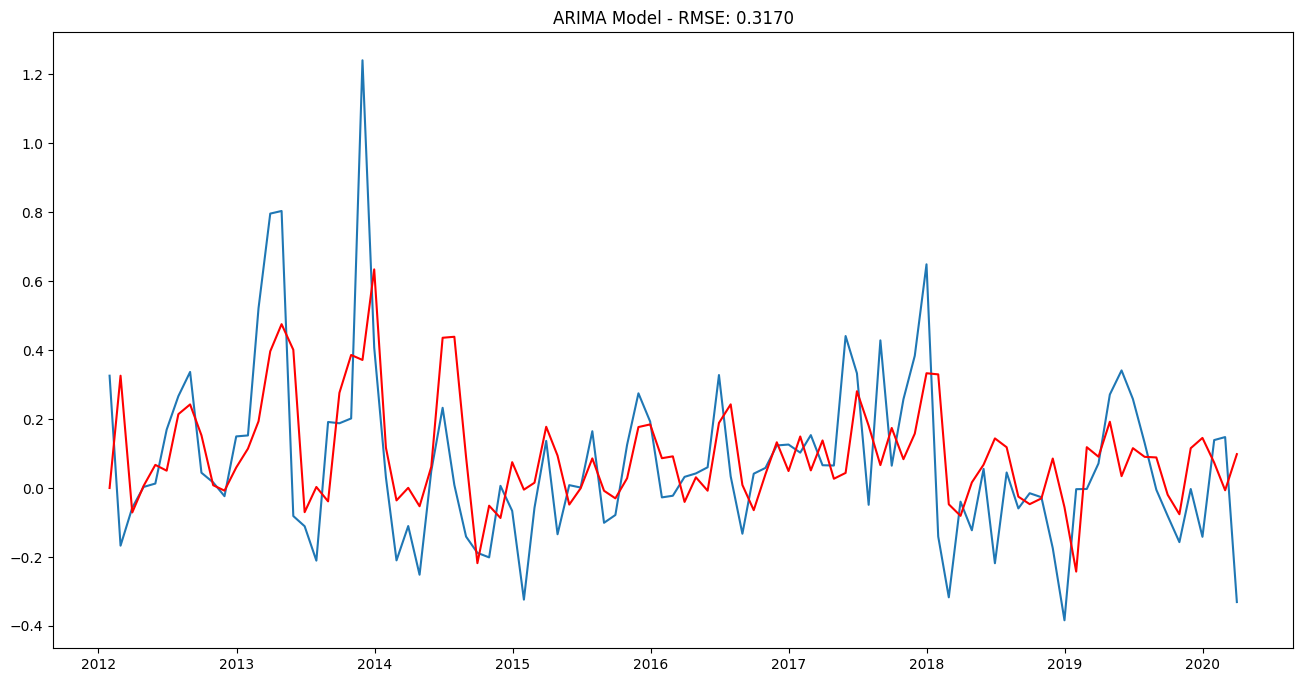

In [38]:
from statsmodels.tsa.arima.model import ARIMA

plt.figure(figsize = (16, 8))

# Using p = 7, d = 1, q = 7
model_ARIMA = ARIMA(df_shift, order = (7, 1, 7))

results_ARIMA = model_ARIMA.fit()

plt.plot(df_shift)

plt.plot(results_ARIMA.fittedvalues, color = 'red')

plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues[1:], df_shift2['Close'], squared = False))

plt.show()

- **The ARIMA model is giving a higher RMSE than other models.**

**Let's check the AIC value** of the model.

In [39]:
# Calculating the AIC
results_ARIMA.aic #5.122248793235144

1.373706301124198

# Model Choice: ARMA

- **The AIC value of the ARIMA model is much higher as compared to previous models.** 

We can see that the ARMA model is giving the least RMSE and the second-lowest AIC value among all the models.

**We can choose to predict the values using ARMA model.**

**Forecasting Steps Summary**
- 1. Forecast Future Values: Use the fitted ARIMA model to predict future values for the next 12 months.
- 2. Calculate Cumulative Sum: Since the forecasts are in differences (log-transformed), compute the cumulative sum to get the actual forecasted values.
- 3. Create a Date Index: Generate a sequence of dates for the next 12 months to serve as the index for the forecasted data.
- 4. Create a DataFrame: Make a new DataFrame that contains the cumulative forecasted values and use the generated dates as the index.
- 5. Add Last Known Value: Add the last actual log-transformed value from the training data to the cumulative forecasted values to get accurate log forecasts.
- 6. Inverse Transformation: Apply the exponential function to convert the log-transformed forecasted values back to their original scale (real prices).
- 7. Plot Results: Visualize the original time series data, the model's predictions on the training data, and the forecasted values for the test data to see how well the model performed.

In [40]:
# Printing the fitted values
predictions = pd.Series(results_ARMA.fittedvalues)

predictions

Timestamp
2012-01-31    0.063516
2012-02-29    0.175579
2012-03-31   -0.069248
2012-04-30    0.025993
2012-05-31    0.053820
                ...   
2019-11-30    0.004503
2019-12-31    0.215969
2020-01-31    0.022534
2020-02-29    0.150100
2020-03-31    0.040955
Length: 99, dtype: float64

## **Inverse Transformation**

Now that we have fitted values using the ARIMA model, **we will use the inverse transformation to get back the original values.**

In [41]:
# First step - doing cumulative sum
predictions_cumsum = predictions.cumsum()

predictions_cumsum

Timestamp
2012-01-31    0.063516
2012-02-29    0.239095
2012-03-31    0.169847
2012-04-30    0.195840
2012-05-31    0.249660
                ...   
2019-11-30    6.826118
2019-12-31    7.042087
2020-01-31    7.064620
2020-02-29    7.214720
2020-03-31    7.255675
Length: 99, dtype: float64

In [42]:
# Second step - adding the first value of the log series to the cumulative sum values
predictions_log = pd.Series(df_log['Close'].iloc[0], index = df_log.index)

predictions_log = predictions_log.add(predictions_cumsum, fill_value = 0)

predictions_log

Timestamp
2011-12-31    1.500181
2012-01-31    1.563697
2012-02-29    1.739276
2012-03-31    1.670028
2012-04-30    1.696021
                ...   
2019-11-30    8.326299
2019-12-31    8.542268
2020-01-31    8.564801
2020-02-29    8.714901
2020-03-31    8.755856
Length: 100, dtype: float64

In [43]:
# Third step - applying exponential transformation
predictions_ARMA = np.exp(predictions_log)

predictions_ARMA

Timestamp
2011-12-31       4.482500
2012-01-31       4.776446
2012-02-29       5.693219
2012-03-31       5.312316
2012-04-30       5.452208
                 ...     
2019-11-30    4131.099953
2019-12-31    5126.956826
2020-01-31    5243.796820
2020-02-29    6093.032875
2020-03-31    6347.751763
Length: 100, dtype: float64

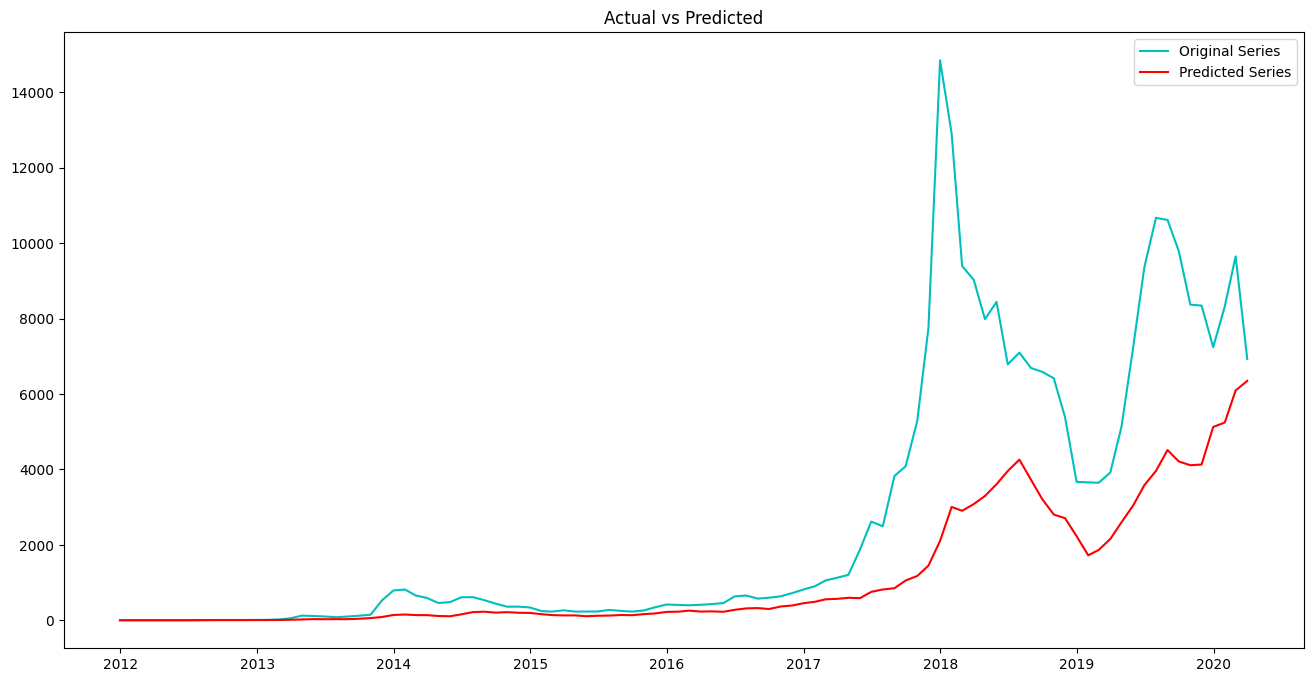

In [44]:
# Plotting the original vs predicted series
plt.figure(figsize = (16, 8))

plt.plot(df_train, color = 'c', label = 'Original Series')

plt.plot(predictions_ARMA, color = 'r', label = 'Predicted Series')

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

**Observations:**
- We can see that **the predicted series is similar to the original series**, i.e., the model is good at predicting values on the training data except for the high spike in prices in 2018 and towards the end of 2019 which may have been due to some external factors that are not included in this model. 
- Let us **forecast the closing prices for the next 12 months.**

## **Forecasting the values for the next 12 months and comparing it with the test data**

**To forecast the values for the next 12 months using the ARMA model, we need to follow the steps below:**
1. Forecast the log-transformed fitted values for the next 12 months.
2. Make a list of these 12 months' forecasted values.
3. Convert that list into a series so that we can work with pandas functions. 
4. Make a dataframe where we have the dates starting from 2020-04-30 to 2021-03-31 as the index and the respective forecasted values.
5. Apply the inverse transformation and get the real forecasted values.

In [45]:
# Forecasting the values for next 12 months where 'steps' represent the number of months
forecasted_ARMA = results_ARMA.forecast(steps = 12)

forecasted_ARMA

2020-04-30   -0.054556
2020-05-31   -0.064410
2020-06-30   -0.078542
2020-07-31   -0.171618
2020-08-31    0.015209
2020-09-30   -0.014593
2020-10-31   -0.091945
2020-11-30   -0.069636
2020-12-31    0.085818
2021-01-31    0.119683
2021-02-28    0.042017
2021-03-31    0.046711
Freq: M, Name: predicted_mean, dtype: float64

In [46]:
# Creating a series of cumulative sum
forecasted_cumsum = forecasted_ARMA.cumsum()

forecasted_cumsum

2020-04-30   -0.054556
2020-05-31   -0.118966
2020-06-30   -0.197508
2020-07-31   -0.369126
2020-08-31   -0.353918
2020-09-30   -0.368511
2020-10-31   -0.460457
2020-11-30   -0.530092
2020-12-31   -0.444274
2021-01-31   -0.324591
2021-02-28   -0.282574
2021-03-31   -0.235863
Freq: M, Name: predicted_mean, dtype: float64

In [47]:
# Making a new dataframe to get the the indices from 2020-2021
index = pd.date_range('2020-04-30', '2021-03-31', freq = '1M')

df1 = pd.DataFrame()

df1['cumsum'] = forecasted_cumsum

df1.index = index

df1

,cumsum
2020-04-30,-0.054556
2020-05-31,-0.118966
2020-06-30,-0.197508
2020-07-31,-0.369126
2020-08-31,-0.353918
2020-09-30,-0.368511
2020-10-31,-0.460457
2020-11-30,-0.530092
2020-12-31,-0.444274
2021-01-31,-0.324591


In [48]:
# Adding the last value of the log of the training data
df1['Forecasted'] = df1['cumsum'] + float(df_log.loc['2020-03-31'])

df1

,cumsum,Forecasted
2020-04-30,-0.054556,8.788907
2020-05-31,-0.118966,8.724498
2020-06-30,-0.197508,8.645955
2020-07-31,-0.369126,8.474337
2020-08-31,-0.353918,8.489545
2020-09-30,-0.368511,8.474952
2020-10-31,-0.460457,8.383007
2020-11-30,-0.530092,8.313371
2020-12-31,-0.444274,8.399189
2021-01-31,-0.324591,8.518872


In [49]:
# Applying the exponential transformation to the forecasted log values
forecasted_ARMA = np.exp(df1['Forecasted'])

forecasted_ARMA

2020-04-30    6561.059941
2020-05-31    6151.786033
2020-06-30    5687.097359
2020-07-31    4790.245772
2020-08-31    4863.655033
2020-09-30    4793.194046
2020-10-31    4372.135374
2020-11-30    4078.037937
2020-12-31    4443.462649
2021-01-31    5008.403313
2021-02-28    5223.325621
2021-03-31    5473.100400
Freq: M, Name: Forecasted, dtype: float64

Now, let's try to visualize the original data with the predicted values on the training data and the forecasted values.

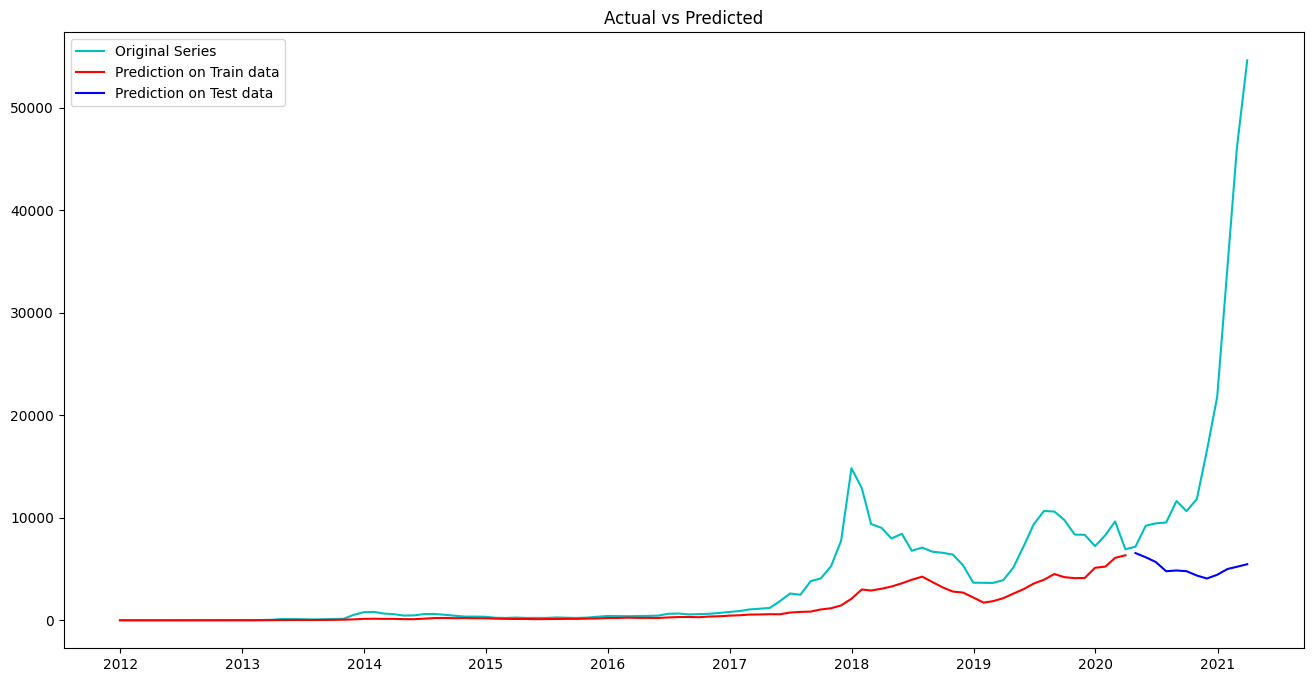

In [50]:
# Plotting the original vs predicted series
plt.figure(figsize = (16, 8))

plt.plot(df, color = 'c', label = 'Original Series')

plt.plot(predictions_ARMA, color = 'r', label = 'Prediction on Train data')

plt.plot(forecasted_ARMA, label = 'Prediction on Test data', color = 'b')

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

**Observations:**

- **As observed earlier, most of the predicted values on the training data are close to the actual values** except for the spike in the prices in the year 2018 and at the end of 2019.
- **On the test data, the model is not performing well**, as we can see that the blue line appears to be far away from the actual values (cyan blue). The actual values have a steep upwards trend, but the predicted values have a somewhat downward trend. Also, the test predictions are not able to identify the volatile variations in the prices over the last 12 months.

Let's test the RMSE of the transformed predictions and the original value on the training and testing data to check whether the model is giving a generalized performance or not.

In [51]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(predictions_ARMA, df_train, squared = False)

error

2777.425692757494

In [52]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(forecasted_ARMA, df_test, squared = False)

error

21600.276026067673

## **Conclusion**

- **Aligned to our observation earlier, the RMSE is lower on the training data** in comparison to the testing data. This implies that the predictions on the training data are closer to the actual values in comparison to the testing data.
- This might be because **there have been many fluctuations in the Bitcoin prices over the last 12 months.** As evident from the above plot, the prices have a steeper trend and more variation in the final year. Our model hasn't learned this from the pattern of previous years and hence the predicted values are not at all close to the actual values.
- As mentioned earlier, one of the varied features of Bitcoin is its large fluctuations in the prices over the last decade. **Our model might not be complex enough to capture these fluctuations - Spikes and Dips.** We can further try to build more complex time series models like SARIMA, SARIMAX, etc., while considering more factors like trend, seasonality, etc. and check if we can get a more generalized model.